In [1]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from highlight_text import ax_text, fig_text
import mplsoccer

In [2]:
#scraping odegaard's data
url ='https://understat.com/player/2517'
html = requests.get(url)
parse_soup = soup(html.content,'lxml')
scripts = parse_soup.find_all('script')
strings = scripts[3].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
x = []
y = []
xg = []
result = []
season = []
lastAction=[]
player_assisted=[]
for i,_ in enumerate(data):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])
        if key=='lastAction':
            lastAction.append(data[i][key])
        if key=='player_assisted':
            player_assisted.append(data[i][key])    
columns = ['X','Y','xG','Result','Season','LastAction','player_assisted']
odegaard_data = pd.DataFrame([x, y, xg, result, season,lastAction,player_assisted], index=columns)
odegaard_data = odegaard_data.T
odegaard_data = odegaard_data.apply(pd.to_numeric,errors='ignore')
#scaling to 100 as opta utilises 100x100 pitches
odegaard_data['X'] = odegaard_data['X'].apply(lambda x:x*100)
odegaard_data['Y'] = odegaard_data['Y'].apply(lambda x:x*100)
print(odegaard_data)


background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Candara'
mpl.rcParams['legend.fontsize'] = 15

             X          Y        xG       Result  Season LastAction  \
0    73.199997  49.900002  0.020139  MissedShots    2019       Pass   
1    78.300003  33.099998  0.074481  MissedShots    2019   Standard   
2    90.800003  51.500000  0.587305         Goal    2019       Pass   
3    98.099998  60.500000  0.148307    SavedShot    2019     TakeOn   
4    90.599998  63.900002  0.195285    SavedShot    2019     TakeOn   
..         ...        ...       ...          ...     ...        ...   
164  77.900002  43.099998  0.030989  BlockedShot    2022       Pass   
165  86.099998  55.500000  0.072782  BlockedShot    2022       None   
166  88.900002  56.599998  0.087024  BlockedShot    2022       None   
167  95.199997  29.200001  0.054818  BlockedShot    2022       Pass   
168  89.099998  52.500000  0.097669  MissedShots    2022      Cross   

         player_assisted  
0          Adnan Januzaj  
1                   None  
2                  Portu  
3        Mikel Oyarzabal  
4        Mik

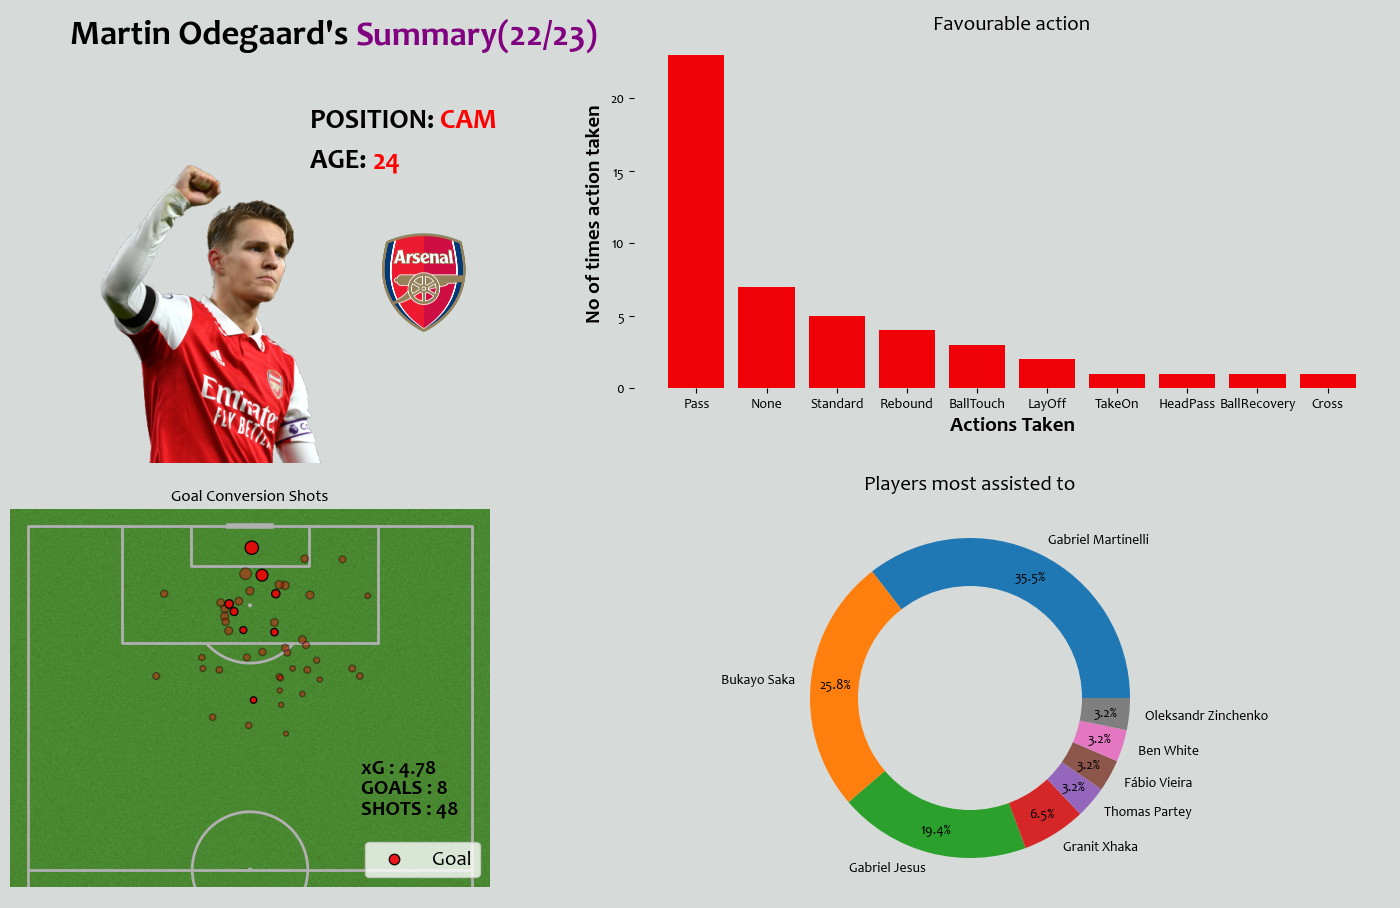

In [3]:
# SETTING UP THE AXES
fig, axes = plt.subplots(figsize=(12,10))
axes.axis('off')
fig.set_facecolor(background)
fig
#SETTING UP THE MPL AXIS 
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta', pitch_color='grass')
ax_opta1 = fig.add_axes((0, 0.06, 0.4, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)

#plotting goals in the 22/23 season
df_fil=odegaard_data.loc[odegaard_data['Season']==2022]
#plotting non goal shots 
pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.4,
              edgecolor='black', facecolor='#EF0107', ax=ax_opta1)
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#EF0107', ax=ax_opta1, label='Goal')

#legends and text
ax_opta1.legend(loc='lower right').get_texts()[0].set_color("black")
ax_opta1.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta1.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta1.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta1.set_title('Goal Conversion Shots')

#plotting bar graph
ax_bar=fig.add_axes([0.52,0.57,0.63,0.35])
ax_bar.set_facecolor(background)
lastaction=df_fil['LastAction'].value_counts()
x=lastaction.keys()
y=lastaction.values
ax_bar.bar(x,y,color="#EF0107")
ax_bar.set_xlabel('Actions Taken', fontdict = {'fontsize':15, 'weight' : 'bold', 'color':text_color})
ax_bar.set_ylabel('No of times action taken', fontdict = dict(fontsize = 15, weight = 'bold',color=text_color))
ax_bar.set_title(label='Favourable action',fontdict = {'fontsize':15, 'color':text_color})
plt.box(False)

#plotting donut chart
ax_donutchart = fig.add_axes((0.60, 0.06, 0.4, 0.4))
donutchartcount=df_fil['player_assisted'].value_counts()
xaxis=donutchartcount.keys()
yaxis=donutchartcount.values
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
ax_donutchart.pie(yaxis, labels=xaxis,autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.70, fc='#D6DBD9')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax_donutchart.set_title(label='Players most assisted to',fontdict = {'fontsize':15, 'color':text_color})


#adding odegaard image
ax_player=fig.add_axes([0,0.43,0.40,0.45])
ax_player.axis('off')
im=plt.imread('odegaard-removebg-preview.png')
ax_player.imshow(im)



# ADDING TITLES AND INFO
fig_text(0.05,0.94,"Martin Odegaard's <Summary(22/23)>",weight='heavy', size=25, highlight_textprops=[{'color':'purple'}])
fig_text(0.25,0.85,'POSITION: <CAM>',weight='bold', size=20, highlight_textprops=[{'color':'red'}])
fig_text(0.25,0.81,'AGE: <24>',weight='bold', size=20, highlight_textprops=[{'color':'red'}])

# ADDING CLUB LOGO
ax_team = fig.add_axes([0.27,0.60,0.15,0.15])
ax_team.axis('off')
im = plt.imread('Arsenal-Logo.png')
ax_team.imshow(im)